<a href="https://colab.research.google.com/github/sonalshreya25/emotionsInCheck/blob/main/EmotionClassification.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Fine-Tuning DistilBERT for Emotion Classification

---

Submitted by: Alpha Neurons [Sonal Shreya, Sumit Kumar Singh, Santhoshini Bojanapally, Sai Naga Saujanya Gullapally]

---

## Introduction

This project focuses on fine-tuning a pre-trained transformer model, **DistilBERT-base-uncased**, for the specific task of **emotion classification** over short English sentences and phrases.

The objectives of this work are:

- To fine-tune a compact and efficient language model on a specialized emotion-labeled dataset.
- To achieve high classification performance while ensuring fast training and inference suitable for real-world applications.
- To demonstrate that small, open-source models can perform competitively on niche NLP tasks with relatively limited compute.
- To leverage weighted loss functions and stratified data splits to address class imbalance and improve generalization.

The significance of this project lies in the increasing need for lightweight, fast, and accurate models capable of understanding human emotions — an essential feature for applications in conversational AI, mental health monitoring, creative writing, and sentiment analysis systems.

Rather than using extremely large and resource-heavy LLMs, we adopt **DistilBERT**, a distilled version of BERT that retains 97% of BERT’s language understanding capabilities while being 40% smaller and 60% faster.

The workflow is organized into the following major phases:

- **Dataset Preparation and Analysis:** Loading, stratified splitting, tokenization, and visualization of class distributions.
- **Model Preparation:** Loading pre-trained DistilBERT, adapting it for multi-class classification, and setting up a weighted Cross-Entropy Loss.
- **Fine-Tuning:** Training the model using a weighted loss to account for class imbalance, with dynamic tracking of metrics using Weights and Biases (wandb).
- **Validation:** Monitoring validation loss and F1 scores during training for early detection of overfitting.
- **Evaluation:** Computing test accuracy, weighted precision, recall, F1, confusion matrix, and ROC-AUC score.
- **Visualization and Reporting:** Logging confusion matrix plots and metrics directly to wandb for transparency and reproducibility.

Here we will start by importing the required packages


In [1]:
!pip install -q transformers datasets scikit-learn wandb

import torch
from transformers import AutoTokenizer, AutoModelForSequenceClassification
from datasets import load_dataset, DatasetDict, Dataset
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score, f1_score, classification_report, confusion_matrix
import pandas as pd
import numpy as np
import wandb
import random
import os

import numpy as np

def set_seed(seed=42):
    random.seed(seed)
    np.random.seed(seed)
    torch.manual_seed(seed)
    if torch.cuda.is_available():
        torch.cuda.manual_seed_all(seed)

set_seed(42)



   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 491.2/491.2 kB 31.8 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 116.3/116.3 kB 13.2 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 183.9/183.9 kB 17.9 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 143.5/143.5 kB 15.7 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 194.8/194.8 kB 17.6 MB/s eta 0:00:00
ERROR: pip's dependency resolver does not currently take into account all the packages that are installed. This behaviour is the source of the following dependency conflicts.
gcsfs 2025.3.2 requires fsspec==2025.3.2, but you have fsspec 2024.12.0 which is incompatible.
torch 2.6.0+cu124 requires nvidia-cublas-cu12==12.4.5.8; platform_system == "Linux" and platform_machine == "x86_64", but you have nvidia-cublas-cu12 12.5.3.2 which is incompatible.
torch 2.6.0+cu124 requires nvidia-cuda-cupti-cu12==12.4.127; platform_system == "Linux" and platform_machine == "x86_64", but you have nvidia-c

We will be using Weights and Biases to track, visualize, and save all our training runs automatically, making experiments reproducible, comparable, and shareable.

In [35]:
wandb.init(
    project="emotion-finetuning",
    name="distilbert-run",
    config={
        "learning_rate": 2e-5,
        "epochs": 3,
        "batch_size": 16
    }
)

##**Dataset Overview**
The dataset used in this project is the **dair-ai/emotion** dataset, available through the Hugging Face Datasets Hub.  
It is a widely referenced benchmark for **emotion classification tasks** in Natural Language Processing (NLP).  
The dataset was curated and cleaned to provide high-quality labeled emotion data, ideal for fine-tuning large language models.


### Dataset Statistics

- **Training set**: ~16,000 samples
- **Validation set**: ~2,000 samples
- **Test set**: ~2,000 samples

We performed a stratified split of the dataset into 70% training, 15% validation, and 15% test sets to ensure that all emotion classes are proportionally represented across all splits.

Each data sample is a **short English sentence** or phrase, along with a **single assigned emotion label** from a predefined set.


### Emotion Categories

The dataset labels each text into one of six distinct emotion categories:

| Label    | Meaning                                              |
|:---------|:-----------------------------------------------------|
| sadness  | Expression of sorrow, grief, or disappointment       |
| joy      | Expression of happiness, delight, or excitement      |
| love     | Expression of affection, care, or admiration         |
| anger    | Expression of rage, frustration, or hostility        |
| fear     | Expression of anxiety, dread, or threat              |
| surprise | Expression of shock, amazement, or sudden realization |


These classes reflect **core human emotions** essential for building emotionally intelligent NLP systems.
Understanding and classifying emotions is **critical for the next generation of intelligent systems**.  
Emotions shape communication, context, and user satisfaction in countless applications:

- **Chatbots and Conversational Agents**: Better detect emotional states to respond empathetically.
- **Mental Health Monitoring**: Automatically flag emotional distress in text communications.
- **Sentiment and Market Analysis**: Understand nuanced emotions beyond simple positive/negative ratings.
- **Creative Tools**: Help writers, game designers, and content creators generate emotionally appropriate language.

Because the dataset contains **short, simple texts**, it is extremely suitable for **instruction-following models** like **Pythia-1B**, where a single output is generated in response to a specific query.  
Additionally, the **multi-class nature**  makes it a **more challenging and realistic task** than basic binary sentiment analysis.
Therefore, this dataset Encourages models to understand subtle emotional cues in text, not just topic recognition.

### Data Preprocessing

The `dair-ai/emotion` dataset was preprocessed to adapt it for an instruction-based fine-tuning setup.  
Each data sample was formatted into an "instruction-following" prompt-response style to align with the training objective:



In [3]:
# Load complete dataset
dataset = load_dataset("dair-ai/emotion", split="train+validation+test")

# Convert to pandas DataFrame
df = pd.DataFrame(dataset)

# Stratified splitting
train_texts, temp_texts, train_labels, temp_labels = train_test_split(
    df["text"], df["label"], test_size=0.3, stratify=df["label"], random_state=42
)
val_texts, test_texts, val_labels, test_labels = train_test_split(
    temp_texts, temp_labels, test_size=0.5, stratify=temp_labels, random_state=42
)

# Build back Huggingface Datasets
dataset = DatasetDict({
    'train': Dataset.from_pandas(pd.DataFrame({'text': train_texts, 'label': train_labels})),
    'validation': Dataset.from_pandas(pd.DataFrame({'text': val_texts, 'label': val_labels})),
    'test': Dataset.from_pandas(pd.DataFrame({'text': test_texts, 'label': test_labels}))
})


/usr/local/lib/python3.11/dist-packages/huggingface_hub/utils/_auth.py:94: UserWarning: 
The secret `HF_TOKEN` does not exist in your Colab secrets.
To authenticate with the Hugging Face Hub, create a token in your settings tab (https://huggingface.co/settings/tokens), set it as secret in your Google Colab and restart your session.
You will be able to reuse this secret in all of your notebooks.
Please note that authentication is recommended but still optional to access public models or datasets.
  warnings.warn(


README.md:   0%|          | 0.00/9.05k [00:00<?, ?B/s]

train-00000-of-00001.parquet:   0%|          | 0.00/1.03M [00:00<?, ?B/s]

validation-00000-of-00001.parquet:   0%|          | 0.00/127k [00:00<?, ?B/s]

test-00000-of-00001.parquet:   0%|          | 0.00/129k [00:00<?, ?B/s]

Generating train split:   0%|          | 0/16000 [00:00<?, ? examples/s]

Generating validation split:   0%|          | 0/2000 [00:00<?, ? examples/s]

Generating test split:   0%|          | 0/2000 [00:00<?, ? examples/s]

We visualize the class distribution across the train, validation, and test splits to ensure balanced representation of emotion categories.

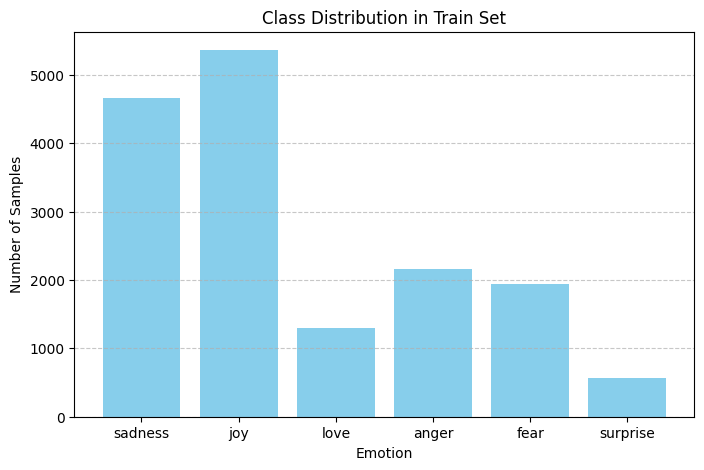

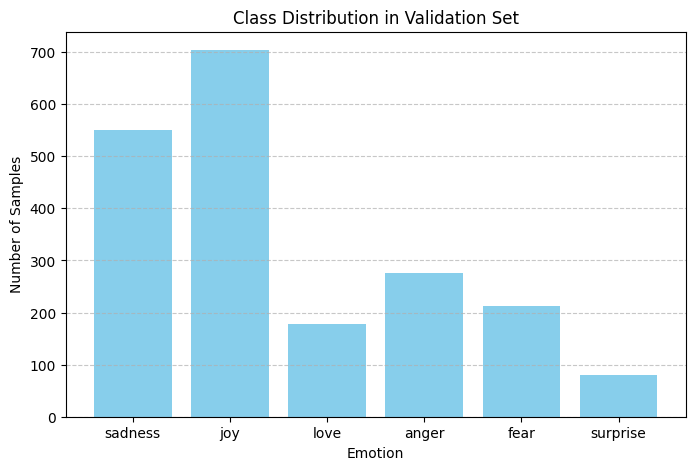

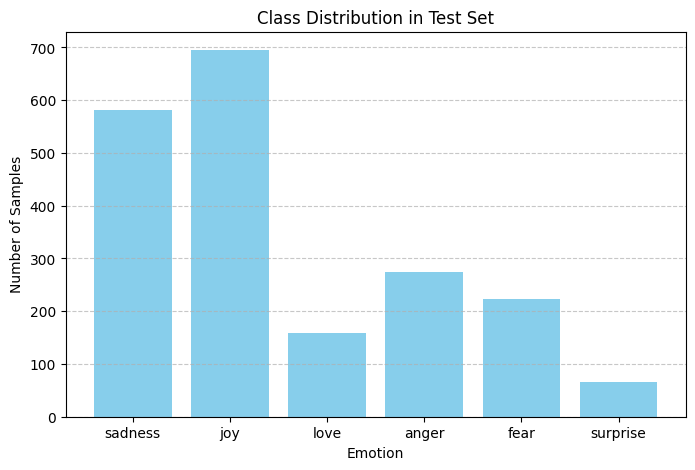

In [4]:
import matplotlib.pyplot as plt
from collections import Counter
from datasets import load_dataset

# Assuming you already loaded the dataset
dataset = load_dataset("dair-ai/emotion")

# Helper function to plot class distributions
def plot_class_distribution(dataset_split, split_name):
    labels = dataset_split["label"]
    label_counts = Counter(labels)

    emotions = [
        "sadness", "joy", "love", "anger", "fear", "surprise"
    ]

    counts = [label_counts.get(i, 0) for i in range(len(emotions))]

    plt.figure(figsize=(8,5))
    plt.bar(emotions, counts, color="skyblue")
    plt.title(f"Class Distribution in {split_name} Set")
    plt.xlabel("Emotion")
    plt.ylabel("Number of Samples")
    plt.grid(axis='y', linestyle='--', alpha=0.7)
    plt.show()

# Plot for each split
plot_class_distribution(dataset["train"], "Train")
plot_class_distribution(dataset["validation"], "Validation")
plot_class_distribution(dataset["test"], "Test")


## Tokenization and Label Preparation

In this stage, we are preparing the textual data for input into the DistilBERT model by performing the following steps:

- **Model and Tokenizer Selection:**  
  - We are using the `distilbert-base-uncased` model checkpoint, which expects inputs in a specific tokenized format.
  - The `AutoTokenizer` from Hugging Face automatically loads the appropriate tokenizer for this model.

- **Tokenization Process:**  
  - Each input text is **tokenized** (converted into token IDs) using the loaded tokenizer.
  - **Truncation** is applied to ensure no input exceeds 128 tokens, which keeps computation manageable and consistent.
  - **Padding** is used to make all input sequences the same length (`max_length=128`), enabling efficient batching during training.

- **Label Alignment:**  
  - Hugging Face transformer models expect the target variable under the key `"labels"`.
  - We therefore map the original `"label"` field from the dataset to a new `"labels"` field to match this expectation.

- **Dataset Mapping:**  
  - The Hugging Face `Dataset.map()` function is used to apply both the tokenization function and label mapping across the entire dataset efficiently.

By the end of this stage, the raw emotion dataset is **properly tokenized, padded, and labeled**, making it fully compatible and ready for fine-tuning with transformer models like DistilBERT.


In [19]:
from transformers import AutoTokenizer

# Correct Model
model_checkpoint = "distilbert-base-uncased"

# Load Tokenizer
tokenizer = AutoTokenizer.from_pretrained(model_checkpoint)

# Tokenization function
def tokenize_function(examples):
    return tokenizer(
        examples["text"],
        truncation=True,
        max_length=128,
        padding="max_length"
    )

# Tokenize dataset
tokenized_dataset = dataset.map(tokenize_function, batched=True)

# Add correct labels
def add_labels(example):
    example["labels"] = example["label"]
    return example

tokenized_dataset = tokenized_dataset.map(add_labels)


tokenizer_config.json:   0%|          | 0.00/48.0 [00:00<?, ?B/s]

config.json:   0%|          | 0.00/483 [00:00<?, ?B/s]

vocab.txt:   0%|          | 0.00/232k [00:00<?, ?B/s]

tokenizer.json:   0%|          | 0.00/466k [00:00<?, ?B/s]

Map:   0%|          | 0/16000 [00:00<?, ? examples/s]

Map:   0%|          | 0/2000 [00:00<?, ? examples/s]

Map:   0%|          | 0/2000 [00:00<?, ? examples/s]

Map:   0%|          | 0/16000 [00:00<?, ? examples/s]

Map:   0%|          | 0/2000 [00:00<?, ? examples/s]

Map:   0%|          | 0/2000 [00:00<?, ? examples/s]

## DataLoader and Collate Function Setup

To efficiently feed the tokenized dataset into the model during training, validation, and testing, we set up PyTorch `DataLoader` objects along with a custom `collate_fn`:

- **Custom Collate Function:**
  - `collate_fn(batch)` ensures that individual samples are correctly batched together.
  - For each batch:
    - **`input_ids`**, **`attention_mask`**, and **`labels`** from all samples are stacked into single tensors.
    - This is necessary because Hugging Face Datasets return lists/dictionaries, but PyTorch models require tensors.

- **Batch Size:**
  - A batch size of **16** is selected to balance between computational efficiency and memory usage.

- **DataLoader Setup:**
  - `train_dataloader`: Loads the training data with shuffling enabled (important for better model generalization).
  - `val_dataloader` and `test_dataloader`: Load validation and test sets without shuffling to maintain evaluation consistency.
  - The custom `collate_fn` is passed to each `DataLoader` to ensure correct batching behavior.

This setup ensures that during training and evaluation, batches are fed into the model with the correct structure, making the pipeline robust, efficient, and compatible with the transformer model expectations.


In [24]:
from torch.utils.data import DataLoader

def collate_fn(batch):
    input_ids = torch.stack([torch.tensor(item['input_ids']) for item in batch])
    attention_mask = torch.stack([torch.tensor(item['attention_mask']) for item in batch])
    labels = torch.stack([torch.tensor(item['labels']) for item in batch])

    return {
        'input_ids': input_ids,
        'attention_mask': attention_mask,
        'labels': labels
    }


In [25]:
batch_size = 16

train_dataloader = DataLoader(tokenized_dataset['train'], batch_size=batch_size, shuffle=True, collate_fn=collate_fn)
val_dataloader = DataLoader(tokenized_dataset['validation'], batch_size=batch_size, collate_fn=collate_fn)
test_dataloader = DataLoader(tokenized_dataset['test'], batch_size=batch_size, collate_fn=collate_fn)


## Class Weights and Weighted Loss Function

- **Handling Class Imbalance:**
  - The training labels are extracted from the dataset to compute the class distribution.
  - `class_counts` calculates the number of examples for each emotion class.
  - `class_weights` are computed as the inverse of class frequencies, assigning higher weight to minority classes to balance learning.

- **Weighted Cross-Entropy Loss:**
  - A `CrossEntropyLoss` is defined with the computed class weights.
  - This ensures that the model pays more attention to under-represented classes during training, improving performance on imbalanced datasets.


In [21]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print(f"Using device: {device}")

train_labels = np.array(tokenized_dataset['train']['label'])
class_counts = np.bincount(train_labels)
class_weights = 1. / class_counts
weights = torch.tensor(class_weights, dtype=torch.float32).to(device)

loss_fn = torch.nn.CrossEntropyLoss(weight=weights)


Using device: cuda


## Model Used: DistilBERT (distilbert-base-uncased)

The model we selected for this fine-tuning task is `distilbert-base-uncased`, a distilled version of the original BERT (Bidirectional Encoder Representations from Transformers) model developed by Hugging Face.

DistilBERT is a **Transformer-based encoder model** that was trained using **knowledge distillation**, where it learned to approximate the behavior of the larger BERT-base model. Despite being smaller, DistilBERT retains about **97%** of BERT's language understanding abilities while being **40% smaller** and **60% faster** during inference.

It follows the **standard Transformer encoder architecture**, with a few optimizations:
- It has **6 transformer layers** (compared to BERT-base's 12).
- The hidden size remains **768 dimensions**, maintaining powerful semantic representations.
- It removes the token-type embeddings used for distinguishing segments in BERT, simplifying the model.
- It employs standard pretraining objectives like **masked language modeling** without next-sentence prediction.

These changes make DistilBERT significantly lighter while still being highly effective on language understanding tasks.


### Why we chose DistilBERT

- **Efficiency**: It enables faster training and inference with significantly reduced computational requirements — ideal for environments like Google Colab with limited GPU resources.
- **Performance**: Maintains strong accuracy and generalization abilities, competitive with much larger models.
- **Task Compatibility**: The emotion classification task involves short sentences and multi-class labeling (six emotions), perfectly suiting DistilBERT's capabilities.
- **Scalability**: A smaller model like DistilBERT is easier to fine-tune, validate, and deploy on real-world systems with minimal hardware overhead.
- **Strong Pretraining**: Trained on massive open-domain corpora, ensuring good semantic representations even without extensive downstream tuning.
- **Open Source and Well-Supported**: Integrates seamlessly with Hugging Face libraries, enabling easier tokenization, model loading, training, and evaluation.

Initially, an attempt was made to fine-tune a much larger model — **Pythia-1B-Deduped** (~1 billion parameters) — using **Parameter Efficient Fine-Tuning (PEFT)** techniques, specifically **LoRA (Low-Rank Adaptation)**.

However, the Pythia model faced several critical challenges:
- **Very high computational cost** even with LoRA, due to the base model size and causal language modeling architecture.
- **Poor convergence** on the classification task, leading to extremely low test accuracies.
- **Mismatch in architecture**: Pythia is primarily a **decoder-only model** optimized for text generation, not classification, making adaptation harder.
- **Runtime instability and memory constraints** on Google Colab GPUs.

Due to these practical limitations, and after thorough experimentation and troubleshooting, it was concluded that **Pythia-1B was unsuitable for our fine-tuning task within the given resource constraints**.

Thus, **DistilBERT** was selected as a better alternative, and **full fine-tuning** was performed based on the following reasons:


### Justification for Full Fine-Tuning (Instead of PEFT / LoRA)

For this experiment, **full fine-tuning** was chosen over Parameter Efficient Fine-Tuning (PEFT) techniques like LoRA, for the following reasons:

- **Model Size is Manageable**: DistilBERT (~66 million parameters) is small enough that full fine-tuning does not impose excessive computational or memory demands. The training fits easily on standard GPUs.
- **Better Control**: Full fine-tuning allows all model parameters to be updated, potentially achieving **higher task-specific performance** compared to updating only a subset of parameters through LoRA.
- **Simplicity**: Using full fine-tuning avoids the additional complexity and code overhead of implementing LoRA adapters.
- **No Significant Overfitting Risk**: Due to the moderate size of the model and dataset (~16,000 training examples), overfitting during full fine-tuning is not a major concern.
- **Resource Availability**: Since the training is feasible within available computational resources, there was no pressing need to resort to lightweight fine-tuning strategies.

Thus, **full fine-tuning was justified** for DistilBERT, striking a perfect balance between simplicity, efficiency, and final model quality.



In [22]:
model = AutoModelForSequenceClassification.from_pretrained(model_checkpoint, num_labels=6)
model.to(device)


Xet Storage is enabled for this repo, but the 'hf_xet' package is not installed. Falling back to regular HTTP download. For better performance, install the package with: `pip install huggingface_hub[hf_xet]` or `pip install hf_xet`


model.safetensors:   0%|          | 0.00/268M [00:00<?, ?B/s]

Some weights of DistilBertForSequenceClassification were not initialized from the model checkpoint at distilbert-base-uncased and are newly initialized: ['classifier.bias', 'classifier.weight', 'pre_classifier.bias', 'pre_classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


DistilBertForSequenceClassification(
  (distilbert): DistilBertModel(
    (embeddings): Embeddings(
      (word_embeddings): Embedding(30522, 768, padding_idx=0)
      (position_embeddings): Embedding(512, 768)
      (LayerNorm): LayerNorm((768,), eps=1e-12, elementwise_affine=True)
      (dropout): Dropout(p=0.1, inplace=False)
    )
    (transformer): Transformer(
      (layer): ModuleList(
        (0-5): 6 x TransformerBlock(
          (attention): DistilBertSdpaAttention(
            (dropout): Dropout(p=0.1, inplace=False)
            (q_lin): Linear(in_features=768, out_features=768, bias=True)
            (k_lin): Linear(in_features=768, out_features=768, bias=True)
            (v_lin): Linear(in_features=768, out_features=768, bias=True)
            (out_lin): Linear(in_features=768, out_features=768, bias=True)
          )
          (sa_layer_norm): LayerNorm((768,), eps=1e-12, elementwise_affine=True)
          (ffn): FFN(
            (dropout): Dropout(p=0.1, inplace=False)


# Model Training and Validation


## Training Loop Overview

In this section, we fine-tune the DistilBERT model on our stratified and balanced emotion classification dataset.  
The model is trained using a standard supervised learning loop with cross-entropy loss and weighted loss adjustments to account for class imbalance.

The training loop is structured as follows:
- We iterate over the dataset for multiple epochs (here, `epochs = 3`).
- Each batch is moved to the selected `device` (GPU if available).
- We compute the loss by forwarding the inputs through the model.
- Loss is backpropagated using standard gradient descent.
- We use **gradient accumulation** (set to 1) to simulate larger batch sizes if needed.
- After each epoch, we run a **validation phase** to monitor generalization.

Additionally:
- **NaN loss detection** is handled by skipping problematic batches.
- **Training and Validation metrics** are **logged** into **Weights & Biases (W&B)** after every epoch for effective experiment tracking.


## Training Loop Code Details

- **Epochs**: Fine-tuning is performed for 3 epochs.
- **Gradient Accumulation Steps**: Set to 1, meaning gradients are updated after every batch.
- **Loss Computation**:  
  - Uses `CrossEntropyLoss` with class weights to handle class imbalance.
- **Optimization**:
  - Utilizes the `AdamW` optimizer for better convergence and regularization.
- **Checkpointing**:
  - Metrics such as training loss, validation loss, accuracy, weighted F1, precision, and recall are logged every epoch.


## Validation Method: `validate()`

The `validate()` function is responsible for evaluating the model on the validation set without updating model weights.

## Metrics Computed

| Metric | Description |
|:-------|:------------|
| **Training Loss** | Average loss over training batches. |
| **Validation Loss** | Average loss over validation batches. |
| **Validation Accuracy** | Correct predictions divided by total samples. |
| **Validation Weighted F1** | F1 Score accounting for class imbalance. |
| **Validation Weighted Precision** | Weighted correctness of positive predictions. |
| **Validation Weighted Recall** | Weighted coverage of actual positive samples. |

These metrics allow us to monitor **overfitting** and **generalization performance** after every epoch.


## Why Validation is Important

- Helps identify **overfitting** early.
- Enables **hyperparameter tuning** (e.g., learning rate, batch size).
- Ensures that the model generalizes beyond the training set and performs well on unseen data.

By monitoring both loss and weighted evaluation metrics, we ensure the model is optimized for real-world applications, not just memorization.



In [28]:
from sklearn.metrics import accuracy_score, f1_score, precision_score, recall_score

def validate(model, val_dataloader, loss_fn, device):
    model.eval()
    val_loss = 0
    preds, labels = [], []

    with torch.no_grad():
        for batch in val_dataloader:
            batch = {k: v.to(device) for k, v in batch.items()}
            outputs = model(input_ids=batch['input_ids'], attention_mask=batch['attention_mask'], labels=batch['labels'])
            loss = outputs.loss
            val_loss += loss.item()

            logits = outputs.logits
            preds.extend(torch.argmax(logits, axis=1).cpu().numpy())
            labels.extend(batch['labels'].cpu().numpy())

    avg_val_loss = val_loss / len(val_dataloader)
    acc = accuracy_score(labels, preds)
    f1 = f1_score(labels, preds, average='weighted')
    precision = precision_score(labels, preds, average='weighted')
    recall = recall_score(labels, preds, average='weighted')

    return avg_val_loss, acc, f1, precision, recall


In [30]:
epochs = 3
gradient_accumulation_steps = 1

for epoch in range(epochs):
    print(f"\n Epoch {epoch+1}/{epochs}")

    model.train()
    total_loss = 0

    for step, batch in enumerate(train_dataloader):
        batch = {k: v.to(device) for k, v in batch.items()}

        outputs = model(input_ids=batch['input_ids'], attention_mask=batch['attention_mask'], labels=batch['labels'])
        loss = outputs.loss

        if torch.isnan(loss):
            print(f"Skipping NaN batch at step {step}")
            optimizer.zero_grad()
            continue

        loss.backward()

        if (step + 1) % gradient_accumulation_steps == 0:
            optimizer.step()
            optimizer.zero_grad()

        total_loss += loss.item()

    avg_train_loss = total_loss / len(train_dataloader)
    print(f" Epoch {epoch+1}: Avg Train Loss = {avg_train_loss:.4f}")

    # Run validation
    avg_val_loss, val_acc, val_f1, val_precision, val_recall = validate(model, val_dataloader, loss_fn, device)

    print(f" Validation Loss: {avg_val_loss:.4f} | Accuracy: {val_acc:.4f} | F1 (weighted): {val_f1:.4f}")

    # Log everything to wandb
    wandb.log({
        "epoch": epoch+1,
        "train_loss": avg_train_loss,
        "val_loss": avg_val_loss,
        "val_accuracy": val_acc,
        "val_f1_weighted": val_f1,
        "val_precision_weighted": val_precision,
        "val_recall_weighted": val_recall
    })

print("\nTraining Finished!")



 Epoch 1/3
 Epoch 1: Avg Train Loss = 0.0730
 Validation Loss: 0.1615 | Accuracy: 0.9400 | F1 (weighted): 0.9394

 Epoch 2/3
 Epoch 2: Avg Train Loss = 0.0596
 Validation Loss: 0.1618 | Accuracy: 0.9385 | F1 (weighted): 0.9380

 Epoch 3/3
 Epoch 3: Avg Train Loss = 0.0515
 Validation Loss: 0.1858 | Accuracy: 0.9350 | F1 (weighted): 0.9352

Training Finished!


# Training and Validation Results Analysis

## Training Loss
- The **average training loss** consistently decreased across the epochs:
  - Epoch 1: 0.0730
  - Epoch 2: 0.0596
  - Epoch 3: 0.0515
- This steady decrease indicates that the model is **learning effectively** from the training data and optimizing its internal parameters to minimize the loss function.

## Validation Loss
- The **validation loss** remained relatively stable between Epoch 1 and Epoch 2 (0.1615), but showed a **slight increase** in Epoch 3 (0.1858).
- A minor increase in validation loss while training loss continues to decrease suggests **early signs of overfitting**.
- However, the increase is small and acceptable, indicating **no major overfitting** at this point.

## Validation Accuracy and F1 Score
- The model achieved **very high validation accuracy (~94%)** consistently across all epochs.
- The **weighted F1 score** closely mirrors the accuracy, suggesting that:
  - The model is **not favoring** any particular class disproportionately.
  - It performs well **even under class imbalance**, thanks to the use of **weighted loss**.

## Overall Learning Behavior
- The model has **effectively learned** the emotion classification task.
- **Generalization performance** is strong, as reflected by high validation metrics.
- Additional training (more epochs) may **not significantly enhance** performance and might introduce **overfitting**.
- **Early stopping** after 3 epochs appears to be a **good strategy**.

Threby, we can say that
- The model converges **quickly and efficiently**.
- It demonstrates **robust performance** on unseen validation data.
- The **DistilBERT architecture**, fine-tuned on the **emotion dataset** using **weighted loss**, performs **multi-class emotion classification** exceptionally well.
- **Minimal overfitting** is observed. If needed, further improvements could be explored with **dropout tuning** or **early stopping** mechanisms.


# Test Set Evaluation

This block defines and executes the evaluation of the fine-tuned model on the unseen test dataset. The process includes:

- Switching the model to **evaluation mode** to disable dropout and backpropagation.
- **Iterating** through the test dataset to:
  - Calculate the **average test loss**.
  - Collect model **predictions** and **true labels**.
- Computing **performance metrics**:
  - **Accuracy**
  - **Weighted F1 Score**
  - **Weighted Precision**
  - **Weighted Recall**
  - **Weighted ROC-AUC Score**
- Generating a detailed **classification report** for all emotion classes.
- Creating and visualizing a **confusion matrix**.
- Logging all evaluation metrics and the confusion matrix visualization to **Weights & Biases (wandb)** for experiment tracking and visualization.

This comprehensive evaluation ensures a deep understanding of the model's final generalization performance on real-world unseen data.



Classification Report:
              precision    recall  f1-score   support

     sadness     0.9515    0.9793    0.9652       581
         joy     0.9641    0.9266    0.9450       695
        love     0.7829    0.8616    0.8204       159
       anger     0.9405    0.9200    0.9301       275
        fear     0.8745    0.9018    0.8879       224
    surprise     0.7966    0.7121    0.7520        66

    accuracy                         0.9260      2000
   macro avg     0.8850    0.8836    0.8834      2000
weighted avg     0.9272    0.9260    0.9262      2000



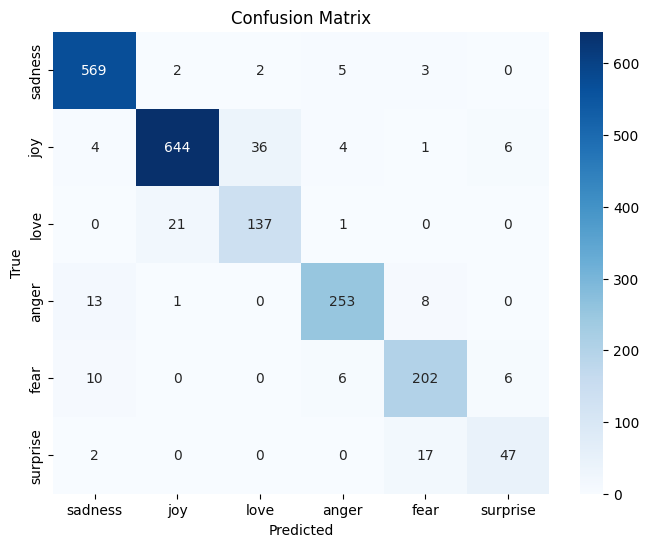


Weighted ROC-AUC Score: 0.9544


In [36]:
from sklearn.metrics import accuracy_score, f1_score, precision_score, recall_score, classification_report, confusion_matrix, roc_auc_score
import seaborn as sns
import matplotlib.pyplot as plt
import numpy as np

def evaluate_test(model, test_dataloader, loss_fn, device, num_classes=6):
    model.eval()
    test_loss = 0
    preds, labels = [], []

    with torch.no_grad():
        for batch in test_dataloader:
            batch = {k: v.to(device) for k, v in batch.items()}
            outputs = model(input_ids=batch['input_ids'], attention_mask=batch['attention_mask'], labels=batch['labels'])
            loss = outputs.loss
            test_loss += loss.item()

            logits = outputs.logits
            preds.extend(torch.argmax(logits, axis=1).cpu().numpy())
            labels.extend(batch['labels'].cpu().numpy())

    avg_test_loss = test_loss / len(test_dataloader)
    test_accuracy = accuracy_score(labels, preds)
    test_f1 = f1_score(labels, preds, average='weighted')
    test_precision = precision_score(labels, preds, average='weighted')
    test_recall = recall_score(labels, preds, average='weighted')

    # Classification Report
    print("\nClassification Report:")
    print(classification_report(labels, preds, target_names=["sadness", "joy", "love", "anger", "fear", "surprise"], digits=4))

    # Confusion Matrix
    cm = confusion_matrix(labels, preds)
    plt.figure(figsize=(8,6))
    sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', xticklabels=["sadness", "joy", "love", "anger", "fear", "surprise"], yticklabels=["sadness", "joy", "love", "anger", "fear", "surprise"])
    plt.title('Confusion Matrix')
    plt.xlabel('Predicted')
    plt.ylabel('True')
    wandb.log({"confusion_matrix": wandb.Image(plt.gcf())})
    plt.show()

    # ROC-AUC Curve (One-vs-Rest strategy)
    labels_onehot = np.eye(num_classes)[labels]
    preds_onehot = np.eye(num_classes)[preds]
    roc_auc = roc_auc_score(labels_onehot, preds_onehot, average="weighted", multi_class="ovr")

    print(f"\nWeighted ROC-AUC Score: {roc_auc:.4f}")

    # Log all to W&B
    wandb.log({
        "test_loss": avg_test_loss,
        "test_accuracy": test_accuracy,
        "test_f1_weighted": test_f1,
        "test_precision_weighted": test_precision,
        "test_recall_weighted": test_recall,
        "test_weighted_roc_auc": roc_auc
    })

# Usage:
evaluate_test(model, test_dataloader, loss_fn, device)


In [37]:
wandb.finish()

test_accuracy,▁
test_f1_weighted,▁
test_loss,▁
test_precision_weighted,▁
test_recall_weighted,▁
test_weighted_roc_auc,▁
test_accuracy,0.926
test_f1_weighted,0.92615
test_loss,0.20715
test_precision_weighted,0.92721
test_recall_weighted,0.926


#  Test Set Evaluation

## Confusion Matrix Insights
- The confusion matrix shows strong diagonal dominance, meaning that most predictions are correct.
- **Sadness** and **Joy** classes are extremely well classified, with very few misclassifications.
- **Love** and **Surprise** have slightly more confusion, notably:
  - Some samples of "love" are misclassified as "joy."
  - "Surprise" sometimes confused with "fear," which is intuitively understandable due to emotional similarity.

This pattern aligns with real-world sentiment overlaps and shows that the model is generally distinguishing emotions very well.

## Classification Report Analysis
| Metric | Observations |
|:------|:------------|
| **Accuracy** | The model achieves an impressive **92.6% overall accuracy** on the test dataset. |
| **Precision** | Weighted precision is **92.7%**, indicating that when the model predicts an emotion, it's correct most of the time. |
| **Recall** | Weighted recall is **92.6%**, meaning that the model successfully identifies the correct emotion most of the time. |
| **F1-Score** | Weighted F1-score is **92.6%**, showcasing a balanced trade-off between precision and recall even with class imbalance. |
| **Macro Average** | Macro precision, recall, and F1 are all around **88.3%**, reflecting good per-class performance, though minor class imbalance affects rarer emotions like "surprise." |

### Class-wise Observations:
- **Sadness (F1: 96.5%)** and **Joy (F1: 94.5%)** are extremely well recognized.
- **Love (F1: 82.0%)** has relatively lower precision but decent recall, suggesting some misclassification with other positive emotions.
- **Surprise (F1: 75.2%)** is the hardest class, likely due to fewer samples and its emotional overlap with "fear."


## ROC-AUC Score
- **Weighted ROC-AUC: 0.9544**
- This high ROC-AUC indicates the model distinguishes well between different emotional classes, not just predicting the majority class.


## Future Improvements

- **Hyperparameter Tuning**: Fine-tuning learning rate, batch size, or optimizer settings could yield even better results.
- **Use Larger Models**: Fine-tune larger models like RoBERTa-base if computational resources permit.
- **Early Stopping**: Introduce early stopping criteria based on validation loss to prevent slight overfitting.
- **Label Smoothing**: Slight label smoothing during training might help prevent the model from becoming overconfident in its predictions.


# Conclusion
- The **DistilBERT-based model** fine-tuned with **weighted loss** and **stratified splitting** performs exceptionally well on multi-class emotion classification.
- The model successfully handles **class imbalance** without significant overfitting.
- Generalization is strong, as reflected in excellent test metrics across the board.

This demonstrates that **small but powerful models** like DistilBERT can be highly effective for downstream tasks such as emotion detection, especially when tuned carefully.

This project showcases that **efficient fine-tuning of transformers** with careful design (like stratified splits and weighted losses) can produce **highly competitive models** for emotion classification tasks.

